In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from scipy.stats import chi2_contingency, shapiro, ttest_ind 
from datetime import datetime

%matplotlib inline
plt.style.use('ggplot')

# A/B test result interpretation
_We have results of an A/B test. There're two groups. How can we describe the results? What metrics should we analyze and how?_

## Let's look at the data

In [12]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [13]:
display(df.head())
print(f"No. of ids: {df.shape[0]} \n")
display(df.info())
print(f"Duplicates: {df.duplicated().sum()}")

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


No. of ids: 404770 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


None

Duplicates: 0


a - control group
b - test group

In [14]:
df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

In [15]:
df_a = df.query("testgroup == 'a'")
df_b = df.query("testgroup == 'b'")

## Let's count some metrics

No. of paying users for ARPPU

In [16]:
a_revenue = df_a.query("revenue > 0")
b_revenue = df_b.query("revenue > 0")

a_revenue_sum = df_a.revenue.sum()
b_revenue_sum = df_b.revenue.sum()

a_count = df_a.user_id.shape[0]
b_count = df_b.user_id.shape[0]

a_pay = a_revenue.revenue.shape[0]
b_pay = b_revenue.revenue.shape[0]

Conversion

In [17]:
a_conv = round(a_pay / a_count * 100,2)
b_conv = round(b_pay / b_count * 100,2)

Min, max, median revenue

In [18]:
a_mean_revenue = a_revenue.revenue.mean()
b_mean_revenue = b_revenue.revenue.mean()
   
a_median_revenue = a_revenue.revenue.median()
b_median_revenue = b_revenue.revenue.median()

a_max_revenue = df_a.revenue.max()
b_max_revenue = df_b.revenue.max()

a_min_revenue = a_revenue.revenue.min()
b_min_revenue = b_revenue.revenue.min()

ARPU/ ARPPU

In [19]:
a_ARPPU = round(a_revenue_sum / a_pay)
b_ARPPU = round(b_revenue_sum / b_pay)

a_ARPU = a_conv * a_ARPPU
b_ARPU = b_conv * b_ARPPU

In [20]:
metrics = pd.DataFrame({'ids': [a_count, b_count],
              'paying_users': [a_pay, b_pay],
              'conversion':[a_conv, b_conv],
              'sum_revenue':[a_revenue_sum, b_revenue_sum],
              'mean_revenue':[a_mean_revenue, b_mean_revenue],
              'median_revenue':[a_median_revenue, b_median_revenue],
              'max_revenue':[a_max_revenue, b_max_revenue],
              'min_revenue':[a_min_revenue, b_min_revenue],
              'ARPU':[a_ARPU, b_ARPU],
              'ARPPU':[a_ARPPU, b_ARPPU]},
            index=['a_control', 'b_test'])
metrics

,ids,paying_users,conversion,sum_revenue,mean_revenue,median_revenue,max_revenue,min_revenue,ARPU,ARPPU
a_control,202103,1928,0.95,5136189,2663.998444,311.0,37433,200,2530.80,2664
b_test,202667,1805,0.89,5421603,3003.658172,3022.0,4000,2000,2673.56,3004


1. Conversion in the test group decreased by 6 per cent
2. Total revenue has grown (285K)
3. Mean revenue in the test group is higher by 400
4. Median revenue has grown by 10 times.

Based on all of this we can say that the test group shows more close revenue values. In the control group we have lots of low-revenue clients and a few ones who pay a lot.

Let's look at the charts to get a better view.

<AxesSubplot: xlabel='revenue', ylabel='Count'>

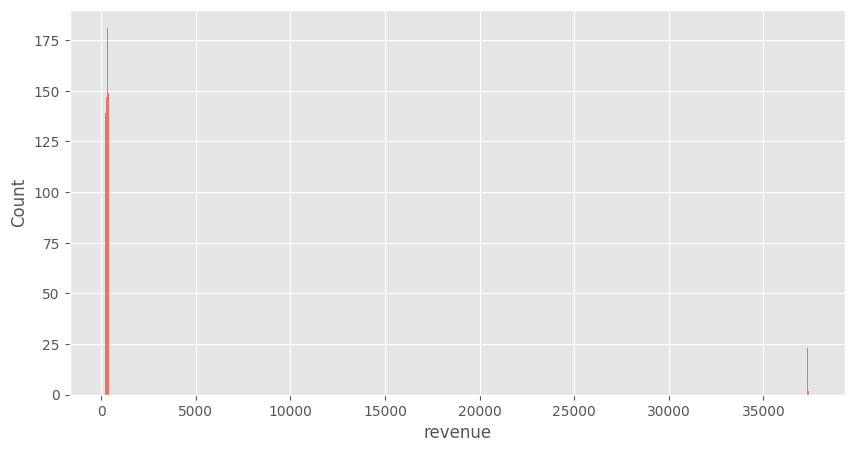

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(a_revenue.revenue)

<AxesSubplot: xlabel='revenue', ylabel='Count'>

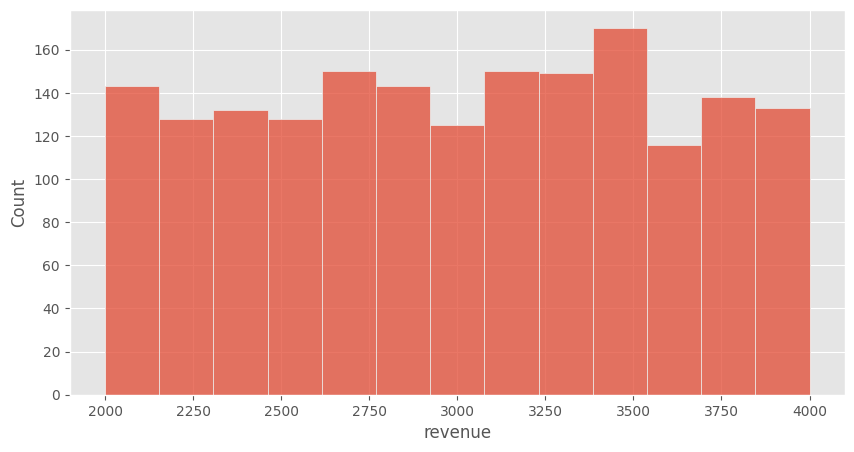

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(b_revenue.revenue)

Let's count the fraction of high-paying client in the control group (testgroup == a)

In [ ]:
max_spent_clients = df_a.query('revenue > 3000').user_id.nunique()
print(f"No. of clients that pay a lot: {max_spent_clients}")
print(f"Which is {round(max_spent_clients / df_a.user_id.nunique(), 5)*100} per cent of the control group")
print(f"Fraction of these clients in the whole revenue sum: {round(df_a.query('revenue > 3000').revenue.sum() / df_a.query('revenue > 0').revenue.sum() * 100, 1)}%")

## Теперь необходимо проверить статистическую значимость полученных изменений в ARPU, ARPPU и конверсии

1. Проверим распределение средних на нормальность (тест Шапиро).
2. Првоерим дисперсии на гомогенность (тест Левена).
3. Применим т-тест для проверки наличия статистически значимой разницы между ARPU в двух группах
4. Повторим то же для ARPPU
5. Используем хи-квадрат в случае конверсии (создадим дихотомическую переменную "купил/ не купил")

### ARPU

Тест Шапиро. Применяем на сэмплированных выборках.

In [24]:
sample_means_a = []
sample_means_b = []
for i in range(100):
    sample_a = df_a.revenue.sample(frac=1, replace=True)
    sample_b = df_b.revenue.sample(frac=1, replace=True)
    
    sample_means_a.append(sample_a.mean())
    sample_means_b.append(sample_b.mean())
    
sp_a = shapiro(sample_means_a)

sp_b = shapiro(sample_means_b)

print(sp_a, sp_b)

ShapiroResult(statistic=0.9779605269432068, pvalue=0.0920826643705368) ShapiroResult(statistic=0.9734942317008972, pvalue=0.04115915298461914)


Принимаем, что средние распределены нормально, а значит можем перейти к проверке тестом Левена и далее к t-тесту.

Проверка тестом Левена на гомогенность дисперсий в группах. Результат выводим в табличку ниже.

In [25]:
pg.homoscedasticity(data=df, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


Переходим к проверке т-тестом

In [26]:
ttest_ind(df_a.revenue, df_b.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Т-тест показал отсутствие статистической значимости в разнице ARPU между контрольной и тестовой группами.

### ARPPU

In [27]:
sample_means_a = []
sample_means_b = []
for i in range(100):
    sample_a = a_revenue.revenue.sample(frac=1, replace=True)
    sample_b = b_revenue.revenue.sample(frac=1, replace=True)
    
    sample_means_a.append(sample_a.mean())
    sample_means_b.append(sample_b.mean())
    
sp_a = shapiro(sample_means_a)

sp_b = shapiro(sample_means_b)

print(sp_a, sp_b)

ShapiroResult(statistic=0.9797733426094055, pvalue=0.12763828039169312) ShapiroResult(statistic=0.988935649394989, pvalue=0.5795148015022278)


In [28]:
ttest_ind(a_revenue.revenue, b_revenue.revenue)

Ttest_indResult(statistic=-1.5917100176862005, pvalue=0.11153459157259497)

Для ARPPU также не видим статистически значимого эффекта от проведения а/б теста.

### Конверсия

Создадим дихотомическую переменную "купил/ не купил"

In [29]:
df['purchased'] = df.revenue > 0 

In [30]:
chi2_contingency(pd.crosstab(df.purchased, df.testgroup))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

Мы увидели, что различия в конверсии статистически значимы. Выведем еще раз фрейм со значением метрик.

In [31]:
metrics

,ids,paying_users,conversion,sum_revenue,mean_revenue,median_revenue,max_revenue,min_revenue,ARPU,ARPPU
a_control,202103,1928,0.95,5136189,2663.998444,311.0,37433,200,2530.80,2664
b_test,202667,1805,0.89,5421603,3003.658172,3022.0,4000,2000,2673.56,3004


## Выводы

На основе анализа трех метрик (ARPU, ARPPU, конверсия), на первый взгляд, у нас имеется только статистически значимая разница в конверсии на 6%. Это может напугать и заставить отказаться от предложения для тестовой группы.
Но характер изменений в структуре покупок клиентов не позволяет однозначно сказать "нет". В контрольной группе основная часть клиентов вносила небольшие платежи, малая часть (123 чел) внесли 90% выручки.
В тестовой группе гораздо более сглаженная картина чеков и в целом выручка больше на 285 тысяч.

Надо разбираться дальше и точно иметь какие-либо уточнения или больше информации об этом исследовании.


# Задание 3

_В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?_

1. DAU - анализируем, насколько подскочила аудитория в дни проведения событий
2. Retention - анализируем удержание клиентов при помощи событий (возвращаются ли пользователи в игру ради событий). Хотя тут надо понимать, что есть пользователи, которые и без событий возвращаются каждый день и верно интерпретировать возможноые скачки метрики.
3. Churn rate - анализируем отток пользователей
4. Конверсия - анализируем конверсию в покупку
5. ARPU/ARPPU - анализируем среднюю доходность с пользователей и платящих пользователей (покупателей внутриигровых предметов). Например, после события у пользователей проснулся интерес к игре и они совершили внутриигровые покупки
6. Время, затраченное на прохождение уровней (не слишком ли быстро, не слишком ли долго). В сравнении со временем нахождения в игре, но не в событии.
7. Воронку прохождения уровней (сколько человек отваливается на n-ном уровне). Возможно, где-то нужно подкрутить время на прохождение или сложность, чтобы меньше людей отваливалось и оставалось недовольными (как от чрезмерной сложности, так и от легкости). Тогда большее число довольных людей останется в игре и после события.

_Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?_

Понятно, что это нужно для того, чтобы вызвать азарт и заставить человека больше времени провести в игре во время события.
Значит нужно уделить особое внимание метрике кол-ва времени, проведенного в самом событии. Плюс отток пользователей, ведь это усложнение, а любое усложнение может вызвать негативную реакцию пользователей.
Плюс можно подкручивать число уровней, на которые откатывается игрок, и проверять отток.
Также можно анализировать изменение DAU при разной сложности.